Updated: 03/01/2024

Looks at the mismatch of several black holes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfitsrd as qnmfits
from multiprocessing import Pool
from spatial_reconstruction import *
from qnm_visualisation import qnm_viz
from matplotlib.animation import FuncAnimation

l_max = 6
n_max = 6
t0 = {0:40., 1:18.5, 2:12., 3:8., 4:5.5, 5:3., 6:1.5, 7:0.}[n_max]

In [32]:
sim64 = qnmfits.SXS(ID=64, zero_time=(2,2))
sim114 = qnmfits.SXS(ID=114, zero_time=(2,2))
sim1419 = qnmfits.SXS(ID=1419, zero_time=(2,2))
sim207 = qnmfits.SXS(ID=207, zero_time=(2,2))

sim305 = qnmfits.SXS(ID=305, zero_time=(2,2))
sim65 = qnmfits.SXS(ID=65, zero_time=(2,2))
sim92 = qnmfits.SXS(ID=92, zero_time=(2,2))

# Negative spin BHs: 64, 114, 207, 1419, 1420, 1421, 1422, 1423,1425, 1427

Found the following files to load from the SXS catalog:
    SXS:BBH:0064v5/Lev5/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0064v5/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0114v5/Lev5/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0114v5/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:1419v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:1419v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0207v5/Lev4/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0207v5/Lev4/rhOverM_Asymptotic_GeometricUnits_CoM.h5


100%|██████████| 114M/114M [00:17<00:00, 6.71MB/s] 


Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0065v5/Lev4/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0065v5/Lev4/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0092v5/Lev5/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0092v5/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5


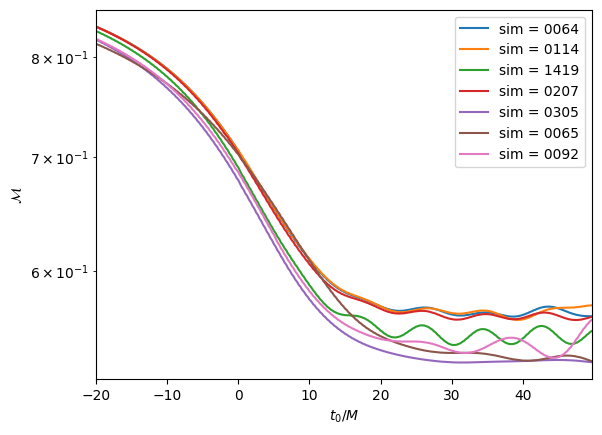

In [33]:
sims = [sim64, sim114, sim1419, sim207, sim305, sim65, sim92]

t0_vals = np.arange(-20, 50, 0.25)

MM = {}
for ref, sim in enumerate(sims):
    
    MM[ref] = np.zeros_like(t0_vals)
    for i, t0 in enumerate(t0_vals):

        modes = [(2,2,n_max,1)]

        best_fit = qnmfits.ringdown_fit(
            sim.times, 
            sim.h[2,2], 
            modes=modes,
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0
        )
    
        MM[ref][i] = best_fit['mismatch']

for ref, sim in enumerate(sims):
    plt.plot(t0_vals, MM[ref], label=f'sim = {sim.ID}')
plt.semilogy()
plt.xlim(min(t0_vals), max(t0_vals))
plt.xlabel(r'$t_0/M$')
plt.ylabel(r'$\mathcal{M}$')
plt.legend()
plt.show()

In [40]:
mapping = [(2,2,0,1)]

sim208 = qnmfits.SXS(ID=208, zero_time=(2,2))

sim = sim208

QNMs = [(lam,mu,n,p) for lam in np.arange(2, l_max+1)
                        for mu in np.arange(-lam, lam+1)
                           for n in np.arange(0, n_max+1)
                              for p in (-1, +1)]

best_fit_linear = qnmfits.mapping_multimode_ringdown_fit(sim.times, 
                                        sim.h, 
                                        modes=QNMs.copy(),
                                        Mf=sim.Mf,
                                        chif=sim.chif_mag,
                                        t0=t0,
                                        mapping_modes=mapping,
                                        spherical_modes=[(l,m) for l in np.arange(2, l_max+1)
                                                               for m in np.arange(-l,l+1)])

Found the following files to load from the SXS catalog:
    SXS:BBH:0208v5/Lev3/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0208v5/Lev3/rhOverM_Asymptotic_GeometricUnits_CoM.h5


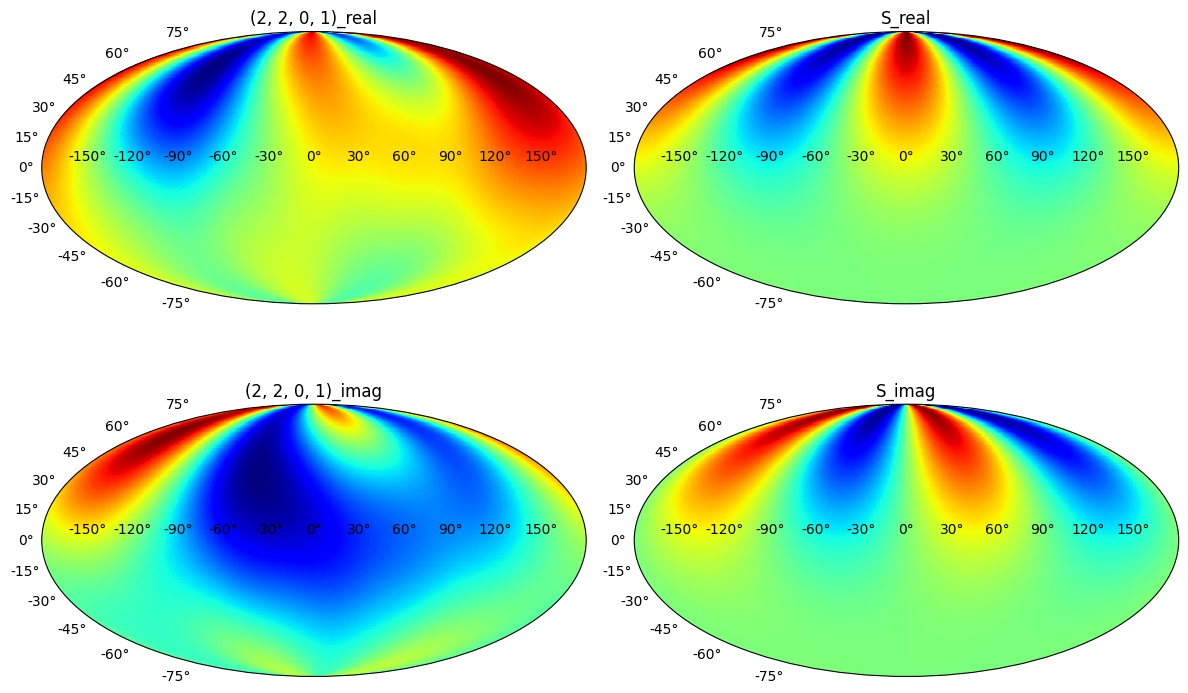

In [41]:
fig, axs = plt.subplots(nrows=2, ncols=2, 
                        subplot_kw={'projection': 'mollweide'}, 
                        figsize=(12,8))

lon = np.linspace(-np.pi, np.pi, 200)
lat = np.linspace(-np.pi/2, np.pi/2, 200)

map = mapping[0]

Lon, Lat = np.meshgrid(lon, lat)
F = mode_mapping(np.pi/2-Lat, Lon, best_fit_linear, map, l_max)
G = spheroidal(np.pi/2-Lat, Lon, map, l_max, sim.chif_mag)

axs[0,0].title.set_text(str(map)+'_real')
axs[0,0].pcolormesh(Lon, Lat, np.real(F), cmap=plt.cm.jet)

axs[1,0].title.set_text(str(map)+'_imag')
axs[1,0].pcolormesh(Lon, Lat, np.imag(F), cmap=plt.cm.jet)

axs[0,1].title.set_text('S_real')
axs[0,1].pcolormesh(Lon, Lat, np.real(G), cmap=plt.cm.jet)

axs[1,1].title.set_text('S_imag')
axs[1,1].pcolormesh(Lon, Lat, np.imag(G), cmap=plt.cm.jet)

plt.tight_layout()
plt.show()